In [ ]:
################################################################################
# This scripts separate the scene image (and meaning maps) into several patches
# to determine scene or meaning maps to separate, just change the defined three paths

# Zhan Shi, Zhicheng Lin, Jan 12, 2025
################################################################################

import os
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

def extract_circular_patches(scene_name, image, degrees, overlap=0.1, save_dir_patch="raw/test", save_dir_meta="raw/test"):
    if not os.path.exists(save_dir_patch):
        os.makedirs(save_dir_patch)

    h, w, _ = image.shape
    patch_count = 0
    metadata = []
    for degree in degrees:
        radius = degree_to_pixel(degree, h, w)
        step = int(radius * (1 - overlap))
        for y in range(0, h, step):
            for x in range(0, w, step):
                mask = create_circular_mask(h, w, center=(x, y), radius=radius)
                patch = np.zeros_like(image)
                patch[mask] = image[mask]

                # Find the bounding box of the circular patch
                coords = np.argwhere(mask)
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)

                # Crop the patch to the bounding box
                cropped_patch = patch[y_min:y_max+1, x_min:x_max+1]
                patch_image = Image.fromarray(cropped_patch)
                patch_filename = f'patch_{patch_count}_deg_{degree}.png'
                patch_image.save(os.path.join(save_dir_patch, patch_filename))

                # Save metadata for reconstruction
                metadata.append({
                    'filename': patch_filename,
                    'center': (x, y),
                    'radius': radius,
                    'bbox': (x_min, y_min, x_max, y_max)
                })

                patch_count += 1

    # Save metadata to a file
    np.save(os.path.join(save_dir_meta, f'{scene_name}_metadata.npy'), metadata)

def degree_to_pixel(degree, h, w):
    # Assuming the image represents a certain field of view, convert degrees to pixels
    # This is a placeholder function and should be adjusted based on actual FOV and image dimensions
    fov = 90  # Example field of view in degrees
    return int((degree / fov) * min(h, w))

def reconstruct_image(metadata_file, original_shape):
    metadata = np.load(metadata_file, allow_pickle=True)
    reconstructed_image = np.zeros(original_shape, dtype=np.uint8)

    for data in metadata:
        patch_image = Image.open(os.path.join(os.path.dirname(metadata_file), data['filename']))
        patch_array = np.array(patch_image)

        x_min, y_min, x_max, y_max = data['bbox']
        mask = create_circular_mask(original_shape[0], original_shape[1], center=data['center'], radius=data['radius'])
        mask_cropped = mask[y_min:y_max+1, x_min:x_max+1]

        reconstructed_image[y_min:y_max+1, x_min:x_max+1][mask_cropped] = patch_array[mask_cropped]

    return Image.fromarray(reconstructed_image)

# Process all scenes in the folder "raw/scenes"
scenes_path = '../autodl-tmp/raw/meaning_maps'
output_patch_dir = '../autodl-tmp/patch_meaning'
output_metadata_dir = '../autodl-tmp/metadata_meaning'

if not os.path.exists(output_patch_dir):
    os.makedirs(output_patch_dir)
if not os.path.exists(output_metadata_dir):
    os.makedirs(output_metadata_dir)

for scene_filename in tqdm(os.listdir(scenes_path)):
    scene_path = os.path.join(scenes_path, scene_filename)
    scene_name, _ = os.path.splitext(scene_filename)

    # Load the scene image
    scene_image = Image.open(scene_path)
    scene_image_np = np.array(scene_image)

    # Define the output directories for patches and metadata
    scene_patch_dir = os.path.join(output_patch_dir, scene_name)
    metadata_dir = output_metadata_dir

    # Extract patches and save metadata
    extract_circular_patches(scene_name, scene_image_np, degrees=[3, 7],
                             save_dir_patch=scene_patch_dir,
                             save_dir_meta=metadata_dir)

In [ ]:
### calculate the label (meaning) for each patch

import os
import numpy as np
from PIL import Image
import csv
from tqdm import tqdm

def calculate_patch_scores_for_scenes(patch_data_folder, metadata_folder, output_csv):
    # Prepare CSV file
    with open(output_csv, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['scene', 'filename', 'center_x', 'center_y', 'radius', 'bbox_x_min', 'bbox_y_min', 'bbox_x_max', 'bbox_y_max', 'mean_score'])

        # Iterate through each scene
        for scene_name in tqdm(os.listdir(patch_data_folder)):
            scene_folder = os.path.join(patch_data_folder, scene_name)
            metadata_file = os.path.join(metadata_folder, f"{scene_name}_metadata.npy")

            if not os.path.exists(metadata_file):
                print(f"Metadata file for scene {scene_name} not found, skipping.")
                continue

            # Load metadata
            metadata = np.load(metadata_file, allow_pickle=True)

            # Iterate through each patch
            for data in metadata:
                patch_image = Image.open(os.path.join(scene_folder, data['filename'])).convert('L')
                patch_array = np.array(patch_image)

                # Calculate the mean of the patch
                non_black_pixels = patch_array[patch_array > 0]
                if non_black_pixels.size > 0:
                    mean_score = np.mean(non_black_pixels)
                else:
                    mean_score = 0

                # Write data to CSV
                writer.writerow([
                    scene_name,
                    data['filename'],
                    data['center'][0], data['center'][1],
                    data['radius'],
                    data['bbox'][0], data['bbox'][1], data['bbox'][2], data['bbox'][3],
                    mean_score
                ])

# Example usage
patch_data_folder = '../autodl-tmp/patch_meaning'
metadata_folder = '../autodl-tmp/metadata_meaning'
output_csv = '../autodl-tmp/patch_scores.csv'
calculate_patch_scores_for_scenes(patch_data_folder, metadata_folder, output_csv)

In [ ]:
### check if all the patch is recorded

import os
import pandas as pd

def check_all_patches_recorded(patch_data_folder, csv_file):
    # Load CSV data
    data = pd.read_csv(csv_file)

    # Create a set of recorded patches with scene and filename
    recorded_patches = set((row['scene'], row['filename']) for _, row in data.iterrows())

    # Iterate through each scene
    for scene_name in os.listdir(patch_data_folder):
        scene_folder = os.path.join(patch_data_folder, scene_name)

        # Iterate through each patch in the scene folder
        for patch_filename in os.listdir(scene_folder):
            if (scene_name, patch_filename) not in recorded_patches:
                print(f"Patch {patch_filename} in scene {scene_name} is not recorded in the CSV file.")
            else:
                recorded_patches.remove((scene_name, patch_filename))

    # Check if there are any extra patches recorded in the CSV
    if recorded_patches:
        for extra_patch in recorded_patches:
            print(f"Extra patch {extra_patch[1]} recorded in the CSV file but not found in the patch data folder for scene {extra_patch[0]}.")

patch_data_folder = '../autodl-tmp/patch_meaning'
csv_file = '../autodl-tmp/patch_scores.csv'
check_all_patches_recorded(patch_data_folder, csv_file)

In [ ]:
### convert the meaning into likert to simulate lab design

import pandas as pd

def mean_score_to_likert(mean_score):
    if mean_score <= 42:
        return 'very low'
    elif mean_score <= 84:
        return 'low'
    elif mean_score <= 126:
        return 'somewhat low'
    elif mean_score <= 168:
        return 'somewhat high'
    elif mean_score <= 210:
        return 'high'
    else:
        return 'very high'

df = pd.read_csv('../autodl-tmp/patch_scores.csv')
df['likert_label'] = df['mean_score'].apply(mean_score_to_likert)
df.to_csv('../autodl-tmp/patch_scores.csv', index=False)

In [8]:
df.shape

(198390, 11)

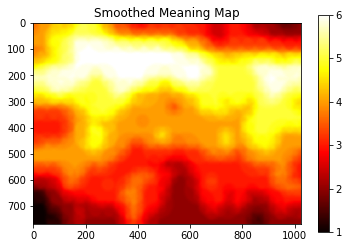

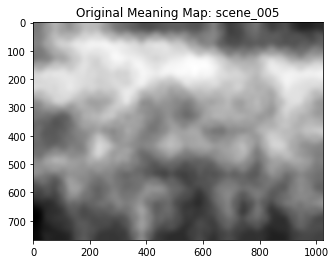

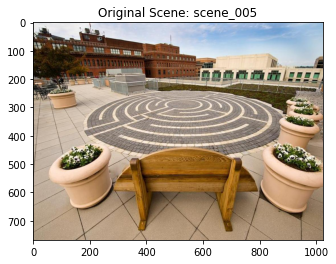

In [10]:
### reconstruct meaning map from the six-point Likert scale of each patch (.csv file)

import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def create_circular_mask(h, w, center=None, radius=None):
    if center is None:  # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radius
    return mask

def likert_to_numeric(likert_label):
    likert_scale = {
        'very low': 1,
        'low': 2,
        'somewhat low': 3,
        'somewhat high': 4,
        'high': 5,
        'very high': 6
    }
    return likert_scale[likert_label]

def plot_smoothed_meaning_map_from_csv(csv_file, original_shape, sigma=5, scene_filter=None):
    # Load CSV data
    data = pd.read_csv(csv_file)

    # Filter data by scene if a scene_filter is provided
    if scene_filter:
        data = data[data['scene'] == scene_filter]

    meaning_map = np.zeros(original_shape[:2], dtype=np.float32)
    count_map = np.zeros(original_shape[:2], dtype=np.float32)

    # Iterate through each row in the CSV
    for _, row in data.iterrows():
        likert_label = row['likert_label']
        numeric_score = likert_to_numeric(likert_label)
        x_min, y_min, x_max, y_max = int(row['bbox_x_min']), int(row['bbox_y_min']), int(row['bbox_x_max']), int(row['bbox_y_max'])
        center = (int(row['center_x']), int(row['center_y']))
        radius = int(row['radius'])

        # Get the mask
        mask = create_circular_mask(original_shape[0], original_shape[1], center=center, radius=radius)
        mask_cropped = mask[y_min:y_max+1, x_min:x_max+1]

        # Place the numeric score in the corresponding location on the meaning map
        meaning_map[y_min:y_max+1, x_min:x_max+1][mask_cropped] += numeric_score
        count_map[y_min:y_max+1, x_min:x_max+1][mask_cropped] += 1

    # Avoid division by zero
    count_map[count_map == 0] = 1
    smoothed_meaning_map = meaning_map / count_map

    # Apply Gaussian filter for smoothing
    smoothed_meaning_map = gaussian_filter(smoothed_meaning_map, sigma=sigma)

    # Plot the smoothed meaning map
    plt.imshow(smoothed_meaning_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Smoothed Meaning Map')
    plt.show()

# Example usage
original_shape = (768, 1024)
scene_filter='scene_005'
csv_file = '../autodl-tmp/patch_scores.csv'
plot_smoothed_meaning_map_from_csv(csv_file, original_shape, scene_filter=scene_filter)

original_meaning_map_path = os.path.join('../autodl-tmp/raw/meaning_maps', scene_filter + '.png')
original_meaning_map = Image.open(original_meaning_map_path)
plt.imshow(original_meaning_map)
plt.title(f'Original Meaning Map: {scene_filter}')
plt.show()

original_scene_path = os.path.join('../autodl-tmp/raw/scenes', scene_filter + '.jpg')
original_scene = Image.open(original_scene_path)
plt.imshow(original_scene)
plt.title(f'Original Scene: {scene_filter}')
plt.show()

In [2]:
### convert the patch ratings into a dataset for fine-tuning LLaVA

import pandas as pd
import numpy as np
import os
import uuid
import json

# Read the CSV file
df = pd.read_csv('../autodl-tmp/patch_scores.csv')

# Split the data into training and testing sets
scenes = df['scene'].unique()
np.random.seed(42)  # For reproducibility
test_scenes = np.random.choice(scenes, size=int(0.3 * len(scenes)), replace=False)
train_df = df[~df['scene'].isin(test_scenes)]
test_df = df[df['scene'].isin(test_scenes)]

instruction = """
Please assess the meaningfulness of the depicted patch using the following scale: 'very low,' 'low,' 'somewhat low,' 'somewhat high,' 'high,' 'very high.'
Provide your response by selecting one of these categories.
"""

def create_dataset(df):
    dataset = []
    for _, row in df.iterrows():
        data_entry = {
            "id": str(uuid.uuid4()),
            "image": os.path.join(row['scene'], row['filename']),
            "conversations": [
                {
                    "from": "human",
                    "value": "<image>\n" + instruction
                },
                {
                    "from": "gpt",
                    "value": row['likert_label']
                }
            ]
        }
        dataset.append(data_entry)
    return dataset

# Create training and testing datasets
train_dataset = create_dataset(train_df)
test_dataset = create_dataset(test_df)

# Save the datasets to JSON files
with open('../autodl-tmp/attention_train.json', 'w') as f:
    json.dump(train_dataset, f, indent=4)

with open('../autodl-tmp/attention_test.json', 'w') as f:
    json.dump(test_dataset, f, indent=4)